<a href="https://colab.research.google.com/github/CBDRH-HDAT9500/week05/blob/master/Week-05-Exercise02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://drive.google.com/uc?export=view&id=1DXUVHxd4t15mfuqMgMCLnsP4jWVI5EWz)

---

<br>
© Copyright The University of New South Wales - CRICOS 00098G

**Author**: Oscar Perez-Concha: o.perezconcha@unsw.edu.au

**Contributors/Co-authors**: Marta Fredes-Torres and Zhisheng (Sandy) Sa.



# Week 7: Artificial Neural Networks / Deep Learning
# Exercise 02: Add regularization to a neural network by using Dropout


# 1. Introduction

In this exercise, we will regularize the deep neural network we built in the previous exercise.

"Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer."

Read: [How to reduce overfitting with dropout regularizationn in keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)

In particular, pay attention to the section: MLP Dropout Regularization.


## 1.1. Aims of the Exercise:

1. This is an introduction to Artificial Neural Networks / Deep Learning with regularisation.
2. We will use Keras.


It aligns with all of our course learning outcomes:

1.	Distinguish a range of task specific machine learning techniques appropriate for Health Data Science.
2.	Design machine learning tasks for Health Data Science scenarios.


## 1.2. Jupyter Notebook Instructions
1. Read the content of each cell.
2. Where necessary, follow the instructions that are written in each cell.
3. Run/Execute all the cells that contain Python code sequentially (one at a time), using the "Run" button.
4. For those cells in which you are asked to write some code, please write the Python code first and then execute/run the cell.

## 1.3. Tips
1. Run all the cells in sequence (one at a time), using the "Run" button.
2. To edit this notebook, just double-click in each cell. Choose between "Code" cell or text "Markdown" cell in the combo-box above.
3. If you want to save your notebook, please go File->Save a copy on Drive/GitHub.
4. To clean the content of all cells and re-start Notebook, please go to Edit->Clear all outputs then Runtime->Restart runtime

Follow the instructions given and if you have any questions, please use the **Comments section** in **Open Learning**.

# 2. Docstring:

Create a docstring with the variables and constants that you will use in this exercise (data dictionary) and the purpose of your program. It is expected that you choose informative variable names and document your program (both docstrings and comments).

<b> Write the answer here:</b>

#####################################################################################################################

(double-click here)


#####################################################################################################################

# 3. Load the Malaria Cell Images Data set

For more information about this dataset, please see [Tensorflow Malaria](https://www.tensorflow.org/datasets/catalog/malaria) and [NLM - Malaria Data](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html)

In [4]:
import sys
print(sys.version)
# FYI: This notebook was created with Python version 3.6.5

import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import random
import warnings; warnings.simplefilter('ignore')

3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [5]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [6]:
# Mount Google Drive
# We do not need to run this cell if you are not running this notebook in Google Colab

if 'google.colab' in str(get_ipython()):
    from google.colab import drive # import drive from Gogle colab
    root = '/content/drive'     # default location for the drive
    # print(root)                 # print content of ROOT (Optional)
    drive.mount(root)
else:
    print('Not running on CoLab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you are running this notebook in Google Colab, you must define your project paths. In this case, define your `project_path`. Otherwise, the model output will be lost after you close the session.

In [7]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    # EDIT THE PROJECT PATH IF DIFFERENT WITH YOUR ONE
    # T
    project_path = Path(root) / 'MyDrive' / 'HDAT9500' / 'week07'

    # OPTIONAL - set working directory according to your google drive project path
    # import os
    # Change directory to the location defined in project_path
    # os.chdir(project_path)
else:
    project_path = Path()

Let's retrieve the arrays "data" and "labels" that we stored in exercise 1 using binary files in NumPy .npy format.

In [8]:
data_path = Path(project_path) / 'data' / 'malaria_img.npz'
with np.load(data_path) as img:
    data = img['data']
    labels = img['labels']

In [9]:
# Sanity Check
print('Cells : {} | labels : {}'.format(data.shape , labels.shape))

Cells : (27558, 12288) | labels : (27558,)


**Splitting the dataset into the Training set and Test set.**

In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0, stratify = labels)

# Sanity Check
print(f'SHAPE OF TRAINING IMAGE DATA : {X_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {X_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (22046, 12288)
SHAPE OF TESTING IMAGE DATA : (5512, 12288)
SHAPE OF TRAINING LABELS : (22046,)
SHAPE OF TESTING LABELS : (5512,)


# 4. Our first ANN using Keras + Dropout


In [11]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten
from keras import backend as K
from keras import optimizers

Please note that the dropout regularisation is a technique to stop over-fitting of the data. The dropout regularisation probabilistically drops a set of nodes during each training epoch. When a node is not available during training, the remaining nodes have to "learn" how to deal with the data being processed. This reduces the ability of the nodes to specialise, and hence prevents over-fitting. The final model does not drop any node; the corresponding weights reflect that learning process of having dropped nodes every now and then during the training stage.

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='brown'> Question 1: We create a function `create_model` that will create the skeleton of the neural network. Add dropout regularisation to the first hidden layer.  </font>

In [12]:
def create_model(DropoutL1):
    # Initiate model
    model = keras.Sequential()
    # Add first hidden layer and input
    model.add(Dense(16, activation='relu', input_dim = X_train.shape[1], kernel_initializer='uniform'))

    # Apply dropout to outputs of hidden layer1
    model.add(Dropout(DropoutL1))

    # Add second hidden layer
    model.add(Dense(16, activation = 'relu', kernel_initializer='uniform'))
    # Add output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

We need a package that acts as  a wrapper between keras and sklearn. [More information](https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f)

In [13]:
# Additional packages
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

We build our model and we call it "ann".

In [14]:
ann = KerasClassifier(build_fn=create_model)

Pipeline and parameter grid for GridSearchCV:

1. Scale the data.

2. GridsearchCV for the correct value of Dropout: The correct solution will be to use a pipeline that scales the data inside GridSearchCV. We know that when we use GridsearchCV, the only option for scaling the data is a pipeline. This is because we carry out cross-validation within the traninig set. That is, we divide the data into training and validation k times (as many as k-CV) in order to tune the hyperparameters. Therefore, we scale the data in different folds every time. A pipeline does it automatically for us.

3. The GridSearchCV will take a long time. Feel free to choose less hyper-parameters, except for the dropout (0.2 and 0.4).

In [15]:
# Pipeline
from sklearn.pipeline  import *

from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
# Scaler2 = MinMaxScaler() # Creates values between zero and 1 vs mean of 0 and SD of 1, does not retain scaled variance

steps=[('Transform', Scaler), ('ANN', ann)]

ann_pipeln = Pipeline(steps)

# Create grid for testing density options. It will take a long time to run. Feel free to use less hyper-parameters.
# param_grid = {'ANN__epochs':[100, 200],
#               'ANN__batch_size': [200, 500],
#               'ANN__DropoutL1':[0.2, 0.4]}

param_grid = {'ANN__epochs':[100],
              'ANN__batch_size': [200],
              'ANN__DropoutL1':[0.2, 0.4]}

# Establish GridSearchCV
grid_search = GridSearchCV(estimator = ann_pipeln, param_grid = param_grid, cv=2)

In [16]:
# Apply Gridsearch, fit the model with the best params identified in the GridSearch
grid_search.fit(X_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                196624    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 196,913
Trainable params: 196,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 3s 24ms/step - loss: 0.6318 - acc: 0.6517
Epoch 2/100
56/56 [==============================] - 3s 56ms/step - loss: 0.5894 - acc:

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Transform', StandardScaler()),
                                       ('ANN',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x78bf6e82fcd0>)]),
             param_grid={'ANN__DropoutL1': [0.2, 0.4], 'ANN__batch_size': [200],
                         'ANN__epochs': [100]})

### <font color='brown'> Question 2: Calculate accuracy, confusion matrix and all the metrics included in classification_report function. </font>

In [17]:
# Write Python code here
grid_search.best_params_

{'ANN__DropoutL1': 0.2, 'ANN__batch_size': 200, 'ANN__epochs': 100}

In [18]:
# make predictions based on the grid search model
y_pred = grid_search.predict(X_test)

173/173 [==============================] - 1s 4ms/step



Accuracy score of grid_search: 0.77

Additional Measures for grid_search:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      2756
           1       0.76      0.80      0.78      2756

    accuracy                           0.77      5512
   macro avg       0.77      0.77      0.77      5512
weighted avg       0.77      0.77      0.77      5512


Confusion Matrix:


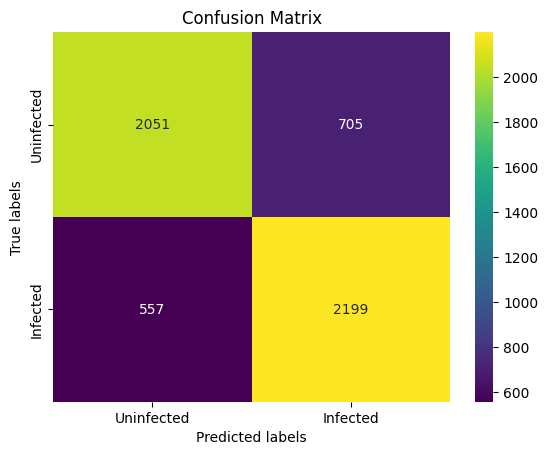

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix

# Determine metrics
# Confusion Matrix
labels = {'Uninfected', 'Infected'}
cm = confusion_matrix(y_test, y_pred)

# Visualising the confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax= ax, cmap="viridis")

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Uninfected', 'Infected']); ax.yaxis.set_ticklabels(['Uninfected', 'Infected'])

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Classification report
cr = classification_report(y_test, y_pred)

# Print metrics
print()
print("Accuracy score of grid_search: {:.2f}".format(accuracy))
print()
print("Additional Measures for grid_search:\n{}".format(cr))
print()
print("Confusion Matrix:")

### <font color='brown'> Question 3: Write your conclusions about the performance and potential use of this classifier.

<b> Write answer here:</b>
#####################################################################################################################

(Double-click here)

#####################################################################################################################

<div class="alert alert-block alert-warning">**End Activity**</div>

© 2022 Copyright The University of New South Wales - CRICOS 00098G